In [1]:
import json
import openai
import requests

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 


import os
from dotenv import load_dotenv
from load_store_utils import cargar_lote_datos
from open_ai_utils import enviar_promt_chat_completions_mode
import warnings

# Ignorar todos los warnings
warnings.filterwarnings('ignore')

# Cargar variables de entorno desde .env
load_dotenv()

# Acceder a la API key
api_key = os.getenv("API_KEY")
openai.api_key = api_key

# Definiendo las herramientas del LLM

In [2]:
tools = [
    {
    "type": "function",
    "function": {
        "name": "cargar_lote_datos",
        "description": "Carga un lote de datos de un archivo CSV basado en el número de muestras especificadas cada muestra representa 1 hora.",
        "parameters": {
            "type": "object",
            "properties": {
                "m_samples": {
                    "type": "integer",
                    "description": "Número de muestras a cargar, si no se proporciona será por defecto 5"
                },
                "formato" : {
                    "type": "string",
                    "enum": ["DataFrame", "numpy"],
                    "description": "Formato en el que se devuelven los datos, DataFrame por defecto"
                }
            },
            "required": ["m_samples"]
        }
    }
}
]

## Extrayendo los datos argumentos del prompt

In [3]:
consulta_usuario_01 = 'cual es el estado del sistema durante las últimos dias'
consulta_usuario = 'Cuales fueron las lecturas de la útlima semana?'
consulta_usuario_02 = 'dime el estado del sistema energético durante las últimas 4 horas'

extraccion_argumentos = [
    {'role': 'system', 'content': f'Tu objetivo es extraer los argumentos necesarios para ejecutar la función que te he pasado en tools'}, 
    {'role': 'user', 'content': f'{consulta_usuario_02}'},
    # {'role': 'assistant', 'content': ''}
]

argumentos_extraidos_del_llm = enviar_promt_chat_completions_mode(
    mensaje=extraccion_argumentos, 
    funciones= tools, 
    forzar_funciones= {"type": "function", "function": {"name": "cargar_lote_datos"}}, 
    aleatoriedad= 0, 
    probabilidad_acumulada=1, 
)

print(argumentos_extraidos_del_llm)

{'m_samples': 4}


## Cargando datos

In [4]:
params = {'name': 'HVAC_test_processeded.csv' , 'ruta_datos':'../data/Anomaly_detection/processed_data/'}
try: 
    data = cargar_lote_datos(**argumentos_extraidos_del_llm, **params)
except TypeError as e: 
    print(e)

display(data)

,T_Supply,T_Return,SP_Return,T_Saturation,T_Outdoor,RH_Supply,RH_Return,RH_Outdoor,Energy,Power,delta_h,KPI,T_wb_out,month,day,hour
Timestamp,,,,,,,,,,,,,,,,
2021-03-29 23:00:00,21.742500,22.4800,21.5,23.330000,18.4,45.715001,34.799999,64.00,0.0,0.000,0.807361,0.220375,5.488130,3,29,23
2021-03-15 08:00:00,22.897499,21.6675,21.5,17.089999,9.8,29.005000,20.480000,48.25,12.5,5.148,16.676441,1.712124,1.811322,3,15,8
2021-03-17 03:00:00,21.222500,21.1575,21.5,21.189999,11.6,29.729999,14.735000,45.75,0.0,0.000,11.619309,1.374794,2.591764,3,17,3
2021-04-10 17:00:00,20.302500,21.0950,21.5,21.070000,15.8,42.705000,31.674999,71.00,0.0,0.000,0.515634,0.093184,4.359261,4,10,17


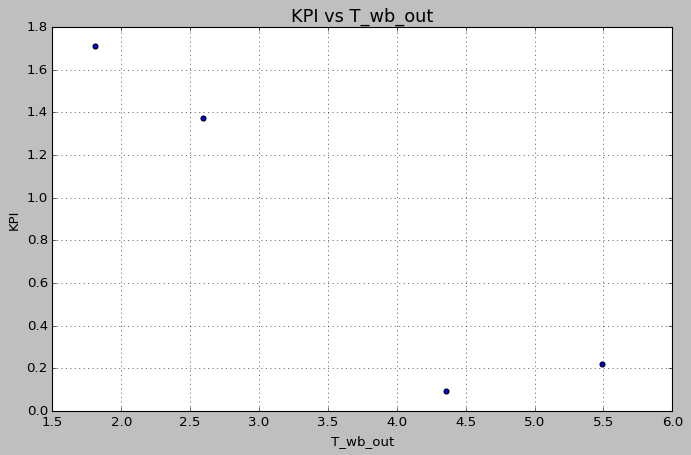

In [5]:
plt.style.use('classic')
plt.figure(figsize=(10, 6))
plt.scatter(x= data['T_wb_out'], y= data['KPI'], )
plt.title('KPI vs T_wb_out', fontsize= 16)
plt.xlabel('T_wb_out', fontsize= 12)
plt.ylabel('KPI', fontsize= 12)

plt.grid()
plt.show()

In [6]:
print(pd.Series(list(data.index)).min())
print(pd.Series(list(data.index)).max())

2021-03-15 08:00:00
2021-04-10 17:00:00


# Pipeline de carga de modelos, procesado de datos y predicción

In [7]:
from load_store_utils import cargar_modelo
from parse import parse_proba_predictions, parse_class_predictions

In [8]:
ruta = './models/anomaly_detection/'        # ruta a los modelos

nombre_scl = 'scaler_trained.pickle'        # el escalador de datos

# los modelos 
nombre_if = 'IF_trained.pickle'             # isolation forest
nombre_ee = 'EE_trained.pickle'             # eliptic envelope
nombre_lof = 'LOF_trained.pickle'           # local outlier factor
nombre_ocsvm = 'OCSVM_trained.pickle'       # one class svm
nombre_gm = 'GM_trained.pickle'             # gaussian mixtures
nombre_knn = 'dbscan_knn.pickle'            # dbscan_knn

# cargamos los modelos
scaler = cargar_modelo(name= nombre_scl, ruta_modelo=ruta)
IF = cargar_modelo(name=nombre_if, ruta_modelo=ruta)
EE = cargar_modelo(name=nombre_ee, ruta_modelo=ruta)
LOF = cargar_modelo(name=nombre_lof, ruta_modelo=ruta)
OCSVM = cargar_modelo(name= nombre_ocsvm, ruta_modelo= ruta)
GM = cargar_modelo(name= nombre_gm, ruta_modelo= ruta)
KNN_dbscan = cargar_modelo(name= nombre_knn, ruta_modelo= ruta)

# escalado de datos
X_test_scl = scaler.transform(data)
X_test_scl_df= pd.DataFrame(X_test_scl, columns= scaler.feature_names_in_, index= data.index)
display(X_test_scl_df)

# predicciones del modelo
model_names = ['isolation_forest', 'Eliptic_Envelope', 'Local_Outlier_Factor', 'One_Class_SVM', 'Gaussian_Mixtures', 'KNN_DBSCAN']
models = [IF, EE, LOF, OCSVM, GM, KNN_dbscan]
dct_models = dict(zip(model_names, models))

models_and_predictions = {}
for name, model in dct_models.items():
    
    if name == 'Gaussian_Mixtures': 
        pred = model.predict_proba(X_test_scl_df)
        predictions = parse_proba_predictions(pred)
    elif name == 'KNN_DBSCAN':
        pred = model.predict(X_test_scl_df)   
        predictions = parse_class_predictions(pred)
    else: 
        predictions = model.predict(X_test_scl_df)

    models_and_predictions[name] = predictions


model_pred_df = pd.DataFrame(models_and_predictions, index= X_test_scl_df.index)
display(model_pred_df)

columnas_base = ['T_Supply', 'T_Return', 'SP_Return', 'T_Saturation', 'T_Outdoor',
                 'RH_Supply', 'RH_Return', 'RH_Outdoor', 'Energy', 'Power']

datos_base = data[columnas_base]
display(datos_base)

Modelo cargado con éxito desde './models/anomaly_detection/scaler_trained.pickle'
Modelo cargado con éxito desde './models/anomaly_detection/IF_trained.pickle'
Modelo cargado con éxito desde './models/anomaly_detection/EE_trained.pickle'
Modelo cargado con éxito desde './models/anomaly_detection/LOF_trained.pickle'
Modelo cargado con éxito desde './models/anomaly_detection/OCSVM_trained.pickle'
Modelo cargado con éxito desde './models/anomaly_detection/GM_trained.pickle'
Modelo cargado con éxito desde './models/anomaly_detection/dbscan_knn.pickle'


,T_Supply,T_Return,SP_Return,T_Saturation,T_Outdoor,RH_Supply,RH_Return,RH_Outdoor,Energy,Power,delta_h,KPI,T_wb_out,month,day,hour
Timestamp,,,,,,,,,,,,,,,,
2021-03-29 23:00:00,0.150292,1.098204,-1.835308,2.191090,1.199687,-0.066265,-0.384514,-0.570571,-0.884262,-0.884357,-1.223728,-0.128649,1.213276,-0.996183,1.493393,1.662036
2021-03-15 08:00:00,0.468983,0.723686,-1.835308,-0.924504,-0.631541,-1.477783,-1.590357,-1.329284,1.262247,1.324790,1.094794,0.076825,-0.583442,-0.996183,-0.106611,-0.504058
2021-03-17 03:00:00,0.006812,0.488605,-1.835308,1.122601,-0.248260,-1.416541,-2.074126,-1.449715,-0.884262,-0.884357,0.355931,0.030361,-0.202069,-0.996183,0.121961,-1.226089
2021-04-10 17:00:00,-0.247037,0.459796,-1.835308,1.062686,0.646060,-0.320524,-0.647661,-0.233365,-0.884262,-0.884357,-1.266350,-0.146169,0.661640,-0.771695,-0.678041,0.795598


,isolation_forest,Eliptic_Envelope,Local_Outlier_Factor,One_Class_SVM,Gaussian_Mixtures,KNN_DBSCAN
Timestamp,,,,,,
2021-03-29 23:00:00,1,1,-1,-1,1,1
2021-03-15 08:00:00,1,1,-1,1,1,1
2021-03-17 03:00:00,1,1,-1,-1,1,1
2021-04-10 17:00:00,1,1,-1,1,1,1


,T_Supply,T_Return,SP_Return,T_Saturation,T_Outdoor,RH_Supply,RH_Return,RH_Outdoor,Energy,Power
Timestamp,,,,,,,,,,
2021-03-29 23:00:00,21.742500,22.4800,21.5,23.330000,18.4,45.715001,34.799999,64.00,0.0,0.000
2021-03-15 08:00:00,22.897499,21.6675,21.5,17.089999,9.8,29.005000,20.480000,48.25,12.5,5.148
2021-03-17 03:00:00,21.222500,21.1575,21.5,21.189999,11.6,29.729999,14.735000,45.75,0.0,0.000
2021-04-10 17:00:00,20.302500,21.0950,21.5,21.070000,15.8,42.705000,31.674999,71.00,0.0,0.000


# Pipeline de texto para el LLM

In [9]:
from calcular_tokens import num_tokens_from_string, num_tokens_from_messages
from open_ai_utils import simular_respuesta_generativa

In [10]:
# pasamos a texto los dataframes y calculamos los tokens de cada tabla
model_pred_texto = model_pred_df.to_markdown()
tokens_pred = num_tokens_from_string(model_pred_texto)

datos_base_texto = datos_base.to_markdown()
tokens_lectura = num_tokens_from_string(datos_base_texto)

descripcion_lectura = datos_base.describe().to_markdown()
tokens_descr = num_tokens_from_string(descripcion_lectura)

# 
simular_respuesta_generativa(f'La tabla de predicciones son {tokens_pred} tokens \n')
simular_respuesta_generativa(model_pred_texto)
print('\n')

simular_respuesta_generativa(f'La tabla de los datos de lectura son {tokens_lectura} tokens \n')
simular_respuesta_generativa(datos_base_texto)
print('\n')

simular_respuesta_generativa(f'La tabla de la descripcion de los datos son {tokens_descr} tokens \n')
simular_respuesta_generativa(descripcion_lectura)
print('\n')

La tabla de predicciones son 221 tokens 
| Timestamp           |   isolation_forest |   Eliptic_Envelope |   Local_Outlier_Factor |   One_Class_SVM |   Gaussian_Mixtures |   KNN_DBSCAN |
|:--------------------|-------------------:|-------------------:|-----------------------:|----------------:|--------------------:|-------------:|
| 2021-03-29 23:00:00 |                  1 |                  1 |                     -1 |              -1 |                   1 |            1 |
| 2021-03-15 08:00:00 |                  1 |                  1 |                     -1 |               1 |                   1 |            1 |
| 2021-03-17 03:00:00 |                  1 |                  1 |                     -1 |              -1 |                   1 |            1 |
| 2021-04-10 17:00:00 |                  1 |                  1 |                     -1 |               1 |                   1 |            1 |

La tabla de los datos de lectura son 385 tokens 
| Timestamp           |   T_Suppl

In [14]:
max_tokens_respuesta = 1000
# mi_consulta = 'hazme un breve informe de lo que ves en la tabla de lecura y dime si cuales de estas lecturas se pueden considerar valores anómalos'
# mi_consulta_2 = "Proporcioname las ultimas 7 lecturas del sistema HVAC"
primer_prompt = [
    {'role': 'system', 'content': f'Eres un asistente de ayuda para un diagnostico de fallos en un sistema energético que genera respuestas concisas. Primero \
                                    generas un informe resumido y breve de lecturas; con número de registros, el maximo y minimo, media, etc. Da las unidades \
                                    de las variables. NO DÉS INFORMACIÓN SOBRE LAS VARIABLES DE LECTURA.  Después, haces un breve resumen de predicciones: \
                                    que lecturas se consideran anomalas según la serie de algoritmos de anomaly detection; 1 valor típico y -1 valor atípico. \
                                    Adecúa tu respuesta a un maximo de {max_tokens_respuesta-100} tokens o más breve'}, 
                                
    {'role': 'user', 'content': f'A partir de la siguiente lectura:\n {datos_base}\n, con descripción: \n {descripcion_lectura}\n y la siguiente \
                                  predicción: \n {model_pred_texto}\n responde a mi consulta: \n{consulta_usuario_02}'},

    {'role': 'assistant', 'content': 'INFORME: \n generas aqui tu informe \n \
                                      PREDICCIÓN: \n comentas de manera concisa y breve que lecuras se consideran anomalas y cuales no por ´mayority voting´\
                                      COCLUSIÓN: \n haz una breve conclusión'}
]
# primer_prompt = [
#     {'role': 'system', 
#      'content': f'Asistente de diagnóstico de fallos en sistemas energéticos. Genera informes concisos sobre datos y anomalías (1: típico, -1: atípico). \
#                   Respuestas limitadas a {max_tokens_respuesta-100} tokens.'},
                
#     {'role': 'user', 
#      'content': f'Lectura: {datos_base}, Descripción: {descripcion_lectura}, Predicción: {model_pred_texto}. Consulta: {consulta_usuario_02}'},

#     {'role': 'assistant', 
#      'content': 'INFORME: Resalta aspectos clave. PREDICCIÓN: Identifica anomalías brevemente. CONCLUSIÓN: Proporciona un resumen.'}
# ]
simular_respuesta_generativa(f'El numero total de tokens de tu prompt es: {num_tokens_from_messages(primer_prompt)}, \n\n')

respuesta = enviar_promt_chat_completions_mode(
            mensaje= primer_prompt, 
            modelo="gpt-4-1106-preview", 
            maximo_tokens=max_tokens_respuesta, 
            aleatoriedad=0.1, 
            probabilidad_acumulada=1)

simular_respuesta_generativa(respuesta)

El numero total de tokens de tu prompt es: 1507, 

INFORME:
- Número de registros: 4
- Rango de temperatura de suministro (T_Supply): Mínimo 20.30, Máximo 22.90, Media 21.54
- Rango de temperatura de retorno (T_Return): Mínimo 21.10, Máximo 22.48, Media 21.60
- Rango de humedad de suministro (RH_Supply): Mínimo 29.01, Máximo 45.72, Media 36.79
- Rango de humedad de retorno (RH_Return): Mínimo 14.74, Máximo 34.80, Media 25.42
- Rango de energía (Energy): Mínimo 0.00, Máximo 12.50, Media 3.13
- Rango de potencia (Power): Mínimo 0.00, Máximo 5.15, Media 1.29

PREDICCIÓN:
- Anomalías detectadas por mayoría de algoritmos: Ninguna (todos los registros tienen una mayoría de valores típicos '1').
- Lecturas típicas: 2021-03-29 23:00:00, 2021-03-15 08:00:00, 2021-03-17 03:00:00, 2021-04-10 17:00:00.
- Lecturas atípicas: No hay lecturas atípicas según la mayoría de algoritmos.

CONCLUSIÓN:
El sistema energético ha funcionado sin anomalías detectadas durante las últimas 4 horas según los algoritm

# Gestionando el dialogo

## opcion 1

In [15]:
conversacion = []
conversacion.append({'role': 'user', 'content': f'{consulta_usuario_02}'})
conversacion.append({'role': 'system', 'content': f'{respuesta}'})

In [19]:
for dialogo in conversacion:
    print(str(dialogo))

{'role': 'user', 'content': 'dime el estado del sistema energético durante las últimas 12 horas'}
{'role': 'system', 'content': 'INFORME:\n- Número de registros: 12\n- T_Supply: Mínimo 18.72, Máximo 27.70, Media 20.97 (Unidades en grados Celsius)\n- T_Return: Mínimo 19.20, Máximo 25.48, Media 21.58 (Unidades en grados Celsius)\n- SP_Return: Mínimo 20.5, Máximo 21.5, Media 21.33 (Unidades en grados Celsius)\n- T_Saturation: Mínimo 17.51, Máximo 25.44, Media 20.39 (Unidades en grados Celsius)\n- T_Outdoor: Mínimo 7.1, Máximo 30.8, Media 16.56 (Unidades en grados Celsius)\n- RH_Supply: Mínimo 25.76, Máximo 50.64, Media 38.98 (Unidades en porcentaje de humedad relativa)\n- RH_Return: Mínimo 14.88, Máximo 40.17, Media 28.07 (Unidades en porcentaje de humedad relativa)\n- RH_Outdoor: Mínimo 25.5, Máximo 79.75, Media 48.80 (Unidades en porcentaje de humedad relativa)\n- Energy: Mínimo 0, Máximo 13, Media 4.71 (Unidades en kWh)\n- Power: Mínimo 0, Máximo 5.17, Media 1.89 (Unidades en kW)\n\nPR

## opcion 2

In [44]:
historico_completo = ''
historico_completo+= 'prompt_usuario_1: \n' + consulta_usuario_02 +'\n'*2
historico_completo+= 'respuesta_sistema_1: \n' + respuesta + '\n'*2
num_tokens_from_string(historico_completo)

518

In [45]:
pregunta_conversacion = 'por que crees que esas lecturas son anomalias? intenta darle una explicabilidad'
prompt_conversacion = [
    {'role': 'system', 'content': f'Eres un asistente de ayuda para un diagnostico de fallos en un sistema energético HVAC que responde de manera concisa sobre un \
                                    informe generado previamente. Siempre pones las unidades de las variables. El historico de la conversación: {historico_completo}\
                                    recuerda: 1 significa valor típico y -1 valor atípico. Tu respuesta debe ser como maximo de {max_tokens_respuesta-100} tokens'}, 
                                
    {'role': 'user', 'content': f'A partir de la siguiente lectura:\n {datos_base}\n, con descripción: \n {descripcion_lectura}\n y la siguiente \
                                  predicción: \n {model_pred_texto}\n responde a mi consulta: \n{pregunta_conversacion}'},

    # {'role': 'assistant', 'content': 'INFORME: \n generas aqui tu informe \n \
    #                                   PREDICCIÓN: \n comentas de manera concisa y breve que lecuras se consideran anomalas y cuales no por ´mayority voting´\
    #                                   COCLUSIÓN: \n haz una breve conclusión'}
]
num_tokens_from_messages(prompt_conversacion)

2882

In [39]:

respuesta_02 = enviar_promt_chat_completions_mode(
            mensaje= prompt_conversacion, 
            modelo="gpt-4-1106-preview", 
            maximo_tokens=max_tokens_respuesta, 
            aleatoriedad=0.1, 
            probabilidad_acumulada=1)

simular_respuesta_generativa(respuesta_02)

Las lecturas del 2021-04-13 12:00:00 y 2021-03-31 16:30:00 han sido identificadas como anomalías por la mayoría de los algoritmos de detección de anomalías. Aquí hay una posible explicación para cada una:

**2021-04-13 12:00:00 (Anomalía)**
- T_Supply: 19.805 °C, que está cerca del promedio de 20.97 °C, no parece anómalo.
- T_Return: 21.575 °C, también cerca del promedio de 21.58 °C, no parece anómalo.
- SP_Return: 21.5 °C, exactamente igual al valor típico.
- T_Saturation: 17.51 °C, que es el mínimo registrado y podría ser considerado bajo en comparación con la media de 20.39 °C.
- T_Outdoor: 22.5 °C, que es más alto que la media de 16.56 °C, pero no extremadamente anómalo.
- RH_Supply: 36.71%, cerca de la media de 38.98%.
- RH_Return: 29.095%, también cerca de la media de 28.07%.
- RH_Outdoor: 36.125%, más bajo que la media de 48.80% pero dentro de un rango normal.
- Energy: 12 kWh, cerca del máximo de 13 kWh, lo que indica un alto consumo de energía.
- Power: 4.938 kW, también cerca

In [46]:
historico_completo+= 'prompt_usuario_2: \n' + pregunta_conversacion +'\n'*2
historico_completo+= 'respuesta_sistema_2: \n' + respuesta_02 + '\n'*2

simular_respuesta_generativa(historico_completo)

prompt_usuario_1: 
dime el estado del sistema energético durante las últimas 12 horas

respuesta_sistema_1: 
INFORME:
- Número de registros: 12
- T_Supply: Mínimo 18.72, Máximo 27.70, Media 20.97 (Unidades en grados Celsius)
- T_Return: Mínimo 19.20, Máximo 25.48, Media 21.58 (Unidades en grados Celsius)
- SP_Return: Mínimo 20.5, Máximo 21.5, Media 21.33 (Unidades en grados Celsius)
- T_Saturation: Mínimo 17.51, Máximo 25.44, Media 20.39 (Unidades en grados Celsius)
- T_Outdoor: Mínimo 7.1, Máximo 30.8, Media 16.56 (Unidades en grados Celsius)
- RH_Supply: Mínimo 25.76, Máximo 50.64, Media 38.98 (Unidades en porcentaje de humedad relativa)
- RH_Return: Mínimo 14.88, Máximo 40.17, Media 28.07 (Unidades en porcentaje de humedad relativa)
- RH_Outdoor: Mínimo 25.5, Máximo 79.75, Media 48.80 (Unidades en porcentaje de humedad relativa)
- Energy: Mínimo 0, Máximo 13, Media 4.71 (Unidades en kWh)
- Power: Mínimo 0, Máximo 5.17, Media 1.89 (Unidades en kW)

PREDICCIÓN:
- Anomalías detectadas 

In [47]:
num_tokens_from_string(historico_completo)

1361

In [48]:
pregunta_conversacion_2 = 'y por que crees que lecturas no son anomalas? no hace falta que me comentes todo, solo lo más relevante'
prompt_conversacion_2 = [
    {'role': 'system', 'content': f'Eres un asistente de ayuda para un diagnostico de fallos en un sistema energético HVAC que responde de manera concisa sobre un \
                                    informe generado previamente. Siempre pones las unidades de las variables. El historico de la conversación: {historico_completo}\
                                    recuerda: 1 significa valor típico y -1 valor atípico. Tu respuesta debe ser como maximo de {max_tokens_respuesta-100} tokens'}, 
                                
    {'role': 'user', 'content': f'A partir de la siguiente lectura:\n {datos_base}\n, con descripción: \n {descripcion_lectura}\n y la siguiente \
                                  predicción: \n {model_pred_texto}\n responde a mi consulta: \n{pregunta_conversacion_2}'},

    # {'role': 'assistant', 'content': 'INFORME: \n generas aqui tu informe \n \
    #                                   PREDICCIÓN: \n comentas de manera concisa y breve que lecuras se consideran anomalas y cuales no por ´mayority voting´\
    #                                   COCLUSIÓN: \n haz una breve conclusión'}
]
num_tokens_from_messages(prompt_conversacion_2)

3732

In [49]:
respuesta_03 = enviar_promt_chat_completions_mode(
            mensaje= prompt_conversacion_2, 
            modelo="gpt-4-1106-preview", 
            maximo_tokens=max_tokens_respuesta, 
            aleatoriedad=0.1, 
            probabilidad_acumulada=1)

simular_respuesta_generativa(respuesta_03)

Las lecturas que no son consideradas anomalías generalmente se ajustan a los patrones típicos del sistema HVAC en términos de temperatura, humedad y consumo de energía. Aquí hay algunos puntos relevantes:

**2021-04-13 10:30:00**
- T_Supply y T_Return están muy cerca de sus medias respectivas.
- T_Saturation y T_Outdoor están dentro de un rango normal.
- RH_Supply, RH_Return y RH_Outdoor están cerca de sus medias.
- Energy y Power están elevados pero no al máximo, lo que podría ser normal dependiendo de la demanda del sistema en ese momento.

**2021-03-13 20:30:00**
- Todas las temperaturas y humedades están cerca de sus medias, sin valores extremos.
- Energy y Power son 0, lo que indica que el sistema no estaba en uso, lo cual es normal dependiendo del horario y la demanda.

**2021-03-27 21:30:00**
- Las temperaturas y humedades están cerca de sus medias.
- No hay un consumo de energía, lo que puede ser normal si el sistema no requería calefacción o refrigeración en ese momento.

Esta

In [50]:
historico_completo+= 'prompt_usuario_3: \n' + pregunta_conversacion_2 +'\n'*2
historico_completo+= 'respuesta_sistema_3: \n' + respuesta_03 + '\n'*2

simular_respuesta_generativa(historico_completo)

prompt_usuario_1: 
dime el estado del sistema energético durante las últimas 12 horas

respuesta_sistema_1: 
INFORME:
- Número de registros: 12
- T_Supply: Mínimo 18.72, Máximo 27.70, Media 20.97 (Unidades en grados Celsius)
- T_Return: Mínimo 19.20, Máximo 25.48, Media 21.58 (Unidades en grados Celsius)
- SP_Return: Mínimo 20.5, Máximo 21.5, Media 21.33 (Unidades en grados Celsius)
- T_Saturation: Mínimo 17.51, Máximo 25.44, Media 20.39 (Unidades en grados Celsius)
- T_Outdoor: Mínimo 7.1, Máximo 30.8, Media 16.56 (Unidades en grados Celsius)
- RH_Supply: Mínimo 25.76, Máximo 50.64, Media 38.98 (Unidades en porcentaje de humedad relativa)
- RH_Return: Mínimo 14.88, Máximo 40.17, Media 28.07 (Unidades en porcentaje de humedad relativa)
- RH_Outdoor: Mínimo 25.5, Máximo 79.75, Media 48.80 (Unidades en porcentaje de humedad relativa)
- Energy: Mínimo 0, Máximo 13, Media 4.71 (Unidades en kWh)
- Power: Mínimo 0, Máximo 5.17, Media 1.89 (Unidades en kW)

PREDICCIÓN:
- Anomalías detectadas 

In [51]:
num_tokens_from_string(historico_completo)

1728

In [1]:
historico_completo = '''prompt_usuario_1: 
dime el estado del sistema energético durante las últimas 12 horas

respuesta_sistema_1: 
INFORME:
- Número de registros: 12
- T_Supply: Mínimo 18.72, Máximo 27.70, Media 20.97 (Unidades en grados Celsius)
- T_Return: Mínimo 19.20, Máximo 25.48, Media 21.58 (Unidades en grados Celsius)
- SP_Return: Mínimo 20.5, Máximo 21.5, Media 21.33 (Unidades en grados Celsius)
- T_Saturation: Mínimo 17.51, Máximo 25.44, Media 20.39 (Unidades en grados Celsius)
- T_Outdoor: Mínimo 7.1, Máximo 30.8, Media 16.56 (Unidades en grados Celsius)
- RH_Supply: Mínimo 25.76, Máximo 50.64, Media 38.98 (Unidades en porcentaje de humedad relativa)
- RH_Return: Mínimo 14.88, Máximo 40.17, Media 28.07 (Unidades en porcentaje de humedad relativa)
- RH_Outdoor: Mínimo 25.5, Máximo 79.75, Media 48.80 (Unidades en porcentaje de humedad relativa)
- Energy: Mínimo 0, Máximo 13, Media 4.71 (Unidades en kWh)
- Power: Mínimo 0, Máximo 5.17, Media 1.89 (Unidades en kW)

PREDICCIÓN:
- Anomalías detectadas por mayoría de algoritmos:
  - 2021-04-13 12:00:00
  - 2021-03-31 16:30:00

CONCLUSIÓN:
Las lecturas de la última semana no pueden ser determinadas con la información proporcionada, ya que no se especifica la fecha actual ni se incluye un rango de fechas que delimite claramente la última semana. Además, el conjunto de datos proporcionado no parece estar ordenado cronológicamente, lo que dificulta la identificación de las lecturas más recientes sin un procesamiento adicional.

prompt_usuario_2: 
por que crees que esas lecturas son anomalias? intenta darle una explicabilidad

respuesta_sistema_2: 
Las lecturas del 2021-04-13 12:00:00 y 2021-03-31 16:30:00 han sido identificadas como anomalías por la mayoría de los algoritmos de detección de anomalías. Aquí hay una posible explicación para cada una:

**2021-04-13 12:00:00 (Anomalía)**
- T_Supply: 19.805 °C, que está cerca del promedio de 20.97 °C, no parece anómalo.
- T_Return: 21.575 °C, también cerca del promedio de 21.58 °C, no parece anómalo.
- SP_Return: 21.5 °C, exactamente igual al valor típico.
- T_Saturation: 17.51 °C, que es el mínimo registrado y podría ser considerado bajo en comparación con la media de 20.39 °C.
- T_Outdoor: 22.5 °C, que es más alto que la media de 16.56 °C, pero no extremadamente anómalo.
- RH_Supply: 36.71%, cerca de la media de 38.98%.
- RH_Return: 29.095%, también cerca de la media de 28.07%.
- RH_Outdoor: 36.125%, más bajo que la media de 48.80% pero dentro de un rango normal.
- Energy: 12 kWh, cerca del máximo de 13 kWh, lo que indica un alto consumo de energía.
- Power: 4.938 kW, también cerca del máximo de 5.17 kW, lo que indica una alta demanda de potencia.

La combinación de una temperatura de saturación baja con un alto consumo de energía y demanda de potencia podría ser la razón por la que los algoritmos han marcado esta lectura como anómala. Podría indicar un funcionamiento ineficiente o un evento no típico, como un ciclo de deshielo o una demanda de refrigeración inusualmente alta.

**2021-03-31 16:30:00 (Anomalía)**
- T_Supply: 27.7025 °C, significativamente más alto que la media y el valor máximo registrado.
- T_Return: 25.4825 °C, también significativamente más alto que la media y el valor máximo registrado para T_Return.
- SP_Return: 21.5 °C, igual al valor típico.
- T_Saturation: 25.44 °C, el máximo registrado y muy por encima de la media.
- T_Outdoor: 30.7999 °C, el máximo registrado y mucho más alto que la media.
- RH_Supply: 41.88%, ligeramente por encima de la media.
- RH_Return: 36.195%, también por encima de la media.
- RH_Outdoor: 40.25%, por debajo de la media pero no anómalo.
- Energy: 13 kWh, el valor máximo registrado.
- Power: 5.172 kW, el valor máximo registrado.

Esta lectura muestra valores extremadamente altos en varias métricas clave, como T_Supply, T_Return, T_Saturation, Energy y Power, lo que sugiere un evento inusual, como una falla del sistema o una condición externa extrema que requiere una refrigeración mucho mayor de lo normal. Estos valores extremos son probablemente la razón por la que ha sido marcada como anómala por la mayoría de los algoritmos.

En ambos casos, las anomalías podrían estar relacionadas con condiciones de funcionamiento inusuales o problemas con el sistema HVAC que requieren atención.

prompt_usuario_3: 
y por que crees que lecturas no son anomalas? no hace falta que me comentes todo, solo lo más relevante

respuesta_sistema_3: 
Las lecturas que no son consideradas anomalías generalmente se ajustan a los patrones típicos del sistema HVAC en términos de temperatura, humedad y consumo de energía. Aquí hay algunos puntos relevantes:

**2021-04-13 10:30:00**
- T_Supply y T_Return están muy cerca de sus medias respectivas.
- T_Saturation y T_Outdoor están dentro de un rango normal.
- RH_Supply, RH_Return y RH_Outdoor están cerca de sus medias.
- Energy y Power están elevados pero no al máximo, lo que podría ser normal dependiendo de la demanda del sistema en ese momento.

**2021-03-13 20:30:00**
- Todas las temperaturas y humedades están cerca de sus medias, sin valores extremos.
- Energy y Power son 0, lo que indica que el sistema no estaba en uso, lo cual es normal dependiendo del horario y la demanda.

**2021-03-27 21:30:00**
- Las temperaturas y humedades están cerca de sus medias.
- No hay un consumo de energía, lo que puede ser normal si el sistema no requería calefacción o refrigeración en ese momento.

Estas lecturas son consideradas no anómalas porque se alinean con el comportamiento esperado del sistema y no presentan valores extremos o patrones inusuales que sugieran un mal funcionamiento o condiciones externas atípicas.
'''

In [1]:
from anomaly_detection import AnomalyDetection

In [2]:
AD = AnomalyDetection()

In [4]:
AD.basic_data.head()

,T_Supply,T_Return,SP_Return,T_Saturation,T_Outdoor,RH_Supply,RH_Return,RH_Outdoor,Energy,Power
0,20.259999,22.404999,21.5,18.110000,17.799999,41.294998,30.559999,51.00,13.5,5.166
1,20.200000,22.452499,21.5,18.149999,17.799999,40.685000,30.210000,56.25,12.5,5.130
2,19.429999,22.422500,21.5,17.919999,17.299999,43.439999,30.154999,55.00,12.5,5.172
3,19.052499,22.309999,21.5,17.369999,16.799999,45.099998,31.184999,57.00,13.5,5.160
4,19.484999,22.184999,21.5,17.339999,15.300000,45.134998,31.820000,58.00,12.5,5.112
